# Distributed SVGD Inference

This guide demonstrates how to perform Bayesian inference using Stein Variational Gradient Descent (SVGD) distributed across multiple nodes and devices.

## What is SVGD?

SVGD is a powerful algorithm for Bayesian inference that:

- Finds the posterior distribution p(θ | data)
- Uses a set of particles to approximate the posterior
- Supports automatic differentiation through JAX
- Scales efficiently to multiple devices

## Overview

We'll demonstrate:

1. Building a parameterized coalescent model
2. Distributing SVGD particles across devices
3. Running Bayesian inference at scale
4. Analyzing posterior distributions

## Setup

First, initialize distributed computing:

In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
from phasic import Graph, initialize_distributed, SVGD
import matplotlib.pyplot as plt


# Initialize distributed computing
dist_info = initialize_distributed(
    platform="cpu",
    enable_x64=True
)

if dist_info.is_coordinator:
    print("Distributed SVGD Inference")
    print("=" * 60)
    print(f"Processes: {dist_info.num_processes}")
    print(f"Total devices: {dist_info.global_device_count}")
    print(f"Local devices: {dist_info.local_device_count}")
    print("=" * 60)

[INFO] Not running under SLURM - using single-node setup
[INFO] Configured JAX for 1 CPU devices
[INFO] JAX x64 precision enabled
[INFO] Single-node setup - no distributed initialization needed
[INFO] 
Distributed Configuration:
  Job ID: N/A
  Process: 0/1
  Coordinator: localhost:12345 (this node)
  Local devices: 1
  Global devices: 1
  Platform: cpu


Distributed SVGD Inference
Processes: 1
Total devices: 1
Local devices: 1


## Building a Parameterized Model

We'll use a coalescent model - this models the time to most recent common ancestor (TMRCA) for a sample of DNA sequences.

### The Coalescent Process

The coalescent is a stochastic model of genealogy that:

- Starts with n sampled lineages
- Lineages coalesce (merge) backwards in time
- Coalescent rate depends on effective population size
- Parameter θ = 4Nμ (population size × mutation rate)

### Model Implementation

In [9]:
def build_coalescent_model(nr_samples=4):
    """
    Build a parameterized coalescent model.
    
    The model has one parameter θ that scales all coalescent rates.
    
    Parameters
    ----------
    nr_samples : int
        Number of sampled sequences
    
    Returns
    -------
    Graph
        Parameterized coalescent graph
    """
    def coalescent_callback(state, nr_samples=nr_samples):
        """Define coalescent transitions."""
        if len(state) == 0:
            # Initial: all samples in separate lineages
            return [(np.array([nr_samples]), 1.0, [1.0])]
        
        if state[0] > 1:
            # Coalescent event: n → n-1 lineages
            n = state[0]
            rate = n * (n - 1) / 2  # Rate = n choose 2
            return [(np.array([n - 1]), 0.0, [rate])]
        
        # Absorbing state (MRCA reached)
        return []
    
    # Build parameterized graph
    graph = Graph(
        callback=coalescent_callback,
        parameterized=True,
        nr_samples=nr_samples
    )
    
    return graph

# Build model
nr_samples = 5
graph = build_coalescent_model(nr_samples=nr_samples)

if dist_info.is_coordinator:
    print(f"\nBuilt coalescent model:")
    print(f"  Samples: {nr_samples}")
    print(f"  States: {graph.vertices_length()}")
    print(f"  Parameters: 1 (θ)")


Built coalescent model:
  Samples: 5
  States: 6
  Parameters: 1 (θ)


## Generating Synthetic Data

For demonstration, we'll generate synthetic data from a known parameter value:

In [10]:
graph.sample(10)

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]


Generated synthetic data:
  True θ: 1.000
  Observations: 30
  Time range: [0.10, 5.00]


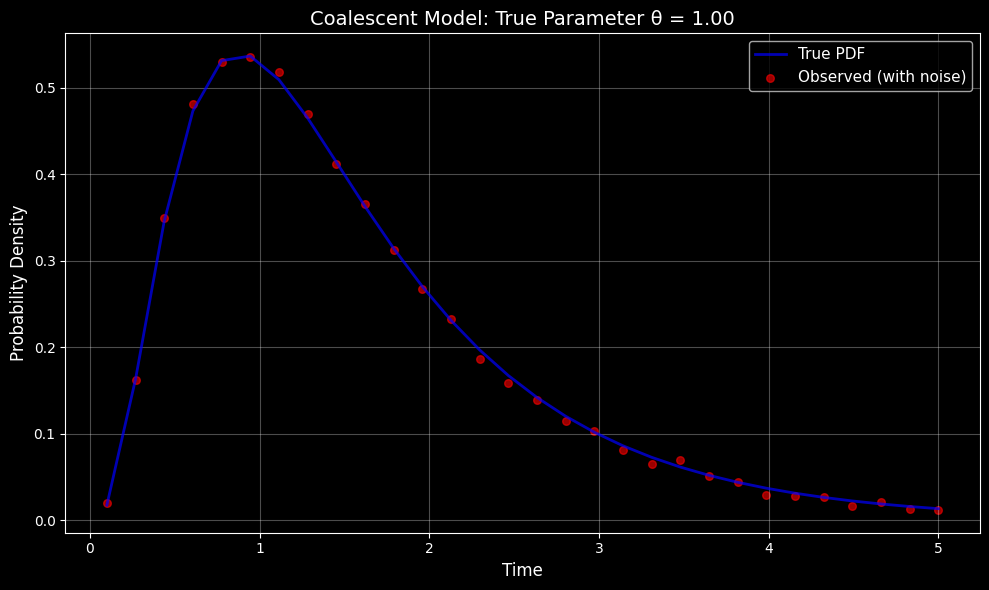

In [11]:
# True parameter value
true_theta = jnp.array([1.0])

# Generate evaluation times
evaluation_times = jnp.linspace(0.1, 5.0, 30)

# Create JAX-compatible model for true parameter
model_fn = Graph.pmf_from_graph(graph, discrete=False)

# Generate true PDF
true_pdf = model_fn(true_theta, evaluation_times)

# Add small noise to simulate observations
np.random.seed(42)
noise = np.random.normal(0, 0.01 * float(jnp.max(true_pdf)), size=true_pdf.shape)
observed_pdf = true_pdf + noise
observed_pdf = jnp.maximum(observed_pdf, 1e-10)  # Ensure positive

if dist_info.is_coordinator:
    print(f"\nGenerated synthetic data:")
    print(f"  True θ: {float(true_theta[0]):.3f}")
    print(f"  Observations: {len(observed_pdf)}")
    print(f"  Time range: [{float(evaluation_times[0]):.2f}, {float(evaluation_times[-1]):.2f}]")
    
    # Visualize data
    plt.figure(figsize=(10, 6))
    plt.plot(evaluation_times, true_pdf, 'b-', linewidth=2, label='True PDF', alpha=0.7)
    plt.scatter(evaluation_times, observed_pdf, color='red', s=30, 
                label='Observed (with noise)', alpha=0.6)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)
    plt.title(f'Coalescent Model: True Parameter θ = {float(true_theta[0]):.2f}', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Setting Up Distributed SVGD

Now we'll configure SVGD to distribute particles across all available devices:

### Key Concepts

- **Particles**: Each particle represents a sample from the posterior
- **Distribution**: Particles are automatically distributed across devices
- **Gradient computation**: Computed in parallel using JAX
- **Communication**: JAX handles inter-device communication

In [12]:
# Configure SVGD
n_particles = dist_info.global_device_count * 8  # 8 particles per device
n_iterations = 300
learning_rate = 0.01

if dist_info.is_coordinator:
    print(f"\nSVGD Configuration:")
    print(f"  Total particles: {n_particles}")
    print(f"  Particles per device: {n_particles // dist_info.global_device_count}")
    print(f"  Iterations: {n_iterations}")
    print(f"  Learning rate: {learning_rate}")

# Initialize particles
np.random.seed(42 + dist_info.process_id)
theta_init = np.random.uniform(0.5, 1.5, size=(n_particles, 1))

# Define prior (weak Gaussian)
def log_prior(theta):
    """Gaussian prior centered at 1.0 with std 2.0"""
    return -0.5 * jnp.sum((theta - 1.0)**2 / (2.0**2))

if dist_info.is_coordinator:
    print(f"\nInitial particle statistics:")
    print(f"  Mean: {np.mean(theta_init):.3f}")
    print(f"  Std: {np.std(theta_init):.3f}")
    print(f"  Range: [{np.min(theta_init):.3f}, {np.max(theta_init):.3f}]")


SVGD Configuration:
  Total particles: 8
  Particles per device: 8
  Iterations: 300
  Learning rate: 0.01

Initial particle statistics:
  Mean: 0.987
  Std: 0.325
  Range: [0.558, 1.451]


## Running SVGD Inference

Now we run SVGD. The computation is automatically distributed across all devices:

In [13]:
# Create SVGD instance
svgd = SVGD(
    model=lambda theta: model_fn(theta, evaluation_times),
    observed_data=observed_pdf,
    prior=log_prior,
    n_particles=n_particles,
    n_iterations=n_iterations,
    learning_rate=learning_rate,
    kernel='median',
    theta_init=theta_init,
    theta_dim=1,
    seed=42,
    verbose=dist_info.is_coordinator  # Only coordinator prints
)

# Run inference (this may take a minute)
if dist_info.is_coordinator:
    print("\nRunning SVGD inference...")
    print("(This may take a minute)\n")

svgd.fit(return_history=True)

# Get results
results = svgd.get_results()

if dist_info.is_coordinator:
    print("\n" + "=" * 60)
    print("INFERENCE COMPLETE")
    print("=" * 60)

Using provided initial particles: (8, 1)
Model type detection failed (assuming pmf only): <lambda>() takes 1 positional argument but 2 were given

Running SVGD inference...
(This may take a minute)


Starting SVGD inference...
  Model: parameterized phase-type distribution
  Data points: 30
  Prior: custom
Running SVGD: 300 steps, 8 particles


ValueError: Model evaluation failed. Ensure model has signature model(theta, times). Error: <lambda>() takes 1 positional argument but 2 were given

## Analyzing Results

Let's examine the posterior distribution:

In [ ]:
if dist_info.is_coordinator:
    # Extract results
    posterior_samples = results['particles']
    posterior_mean = results['theta_mean']
    posterior_std = results['theta_std']
    
    # Compute credible interval
    lower = posterior_mean[0] - 1.96 * posterior_std[0]
    upper = posterior_mean[0] + 1.96 * posterior_std[0]
    
    print(f"\nPosterior Statistics:")
    print(f"  True θ:           {float(true_theta[0]):.4f}")
    print(f"  Posterior mean:   {posterior_mean[0]:.4f}")
    print(f"  Posterior std:    {posterior_std[0]:.4f}")
    print(f"  95% Credible Int: [{lower:.4f}, {upper:.4f}]")
    
    # Check if true value is in credible interval
    if lower <= true_theta[0] <= upper:
        print(f"\nTrue parameter within 95% credible interval")
    else:
        print(f"\n⚠ True parameter outside 95% credible interval")
        print(f"  (Try increasing iterations or particles)")

### Visualize Posterior Distribution

In [ ]:
if dist_info.is_coordinator:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Posterior histogram
    ax = axes[0]
    ax.hist(posterior_samples[:, 0], bins=30, density=True, 
            alpha=0.7, color='blue', edgecolor='black')
    ax.axvline(true_theta[0], color='red', linestyle='--', 
               linewidth=2, label=f'True θ = {float(true_theta[0]):.3f}')
    ax.axvline(posterior_mean[0], color='green', linestyle='-', 
               linewidth=2, label=f'Posterior mean = {posterior_mean[0]:.3f}')
    ax.axvspan(lower, upper, alpha=0.2, color='green', 
               label='95% Credible Interval')
    ax.set_xlabel('θ', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Posterior Distribution', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Right: Convergence (if history available)
    ax = axes[1]
    if 'history' in results and results['history'] is not None:
        history = results['history']
        # Plot particle trajectories (sample a few)
        n_plot = min(20, n_particles)
        for i in range(n_plot):
            ax.plot(history[:, i, 0], alpha=0.3, color='blue', linewidth=0.5)
        ax.axhline(true_theta[0], color='red', linestyle='--', 
                   linewidth=2, label=f'True θ')
        ax.set_xlabel('Iteration', fontsize=12)
        ax.set_ylabel('θ', fontsize=12)
        ax.set_title('SVGD Particle Convergence', fontsize=14)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'History not saved', 
                ha='center', va='center', fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()

### Compare Predictions

Let's compare the posterior predictive distribution with the true model:

In [ ]:
if dist_info.is_coordinator:
    # Posterior predictive: sample from posterior
    n_posterior_samples = 50
    sample_indices = np.random.choice(
        len(posterior_samples), 
        size=n_posterior_samples, 
        replace=False
    )
    
    plt.figure(figsize=(12, 6))
    
    # Plot posterior predictive samples
    for idx in sample_indices:
        theta_sample = jnp.array([posterior_samples[idx, 0]])
        pred_pdf = model_fn(theta_sample, evaluation_times)
        plt.plot(evaluation_times, pred_pdf, 'b-', alpha=0.1, linewidth=1)
    
    # Plot true PDF
    plt.plot(evaluation_times, true_pdf, 'r-', linewidth=3, 
             label=f'True PDF (θ={float(true_theta[0]):.3f})', alpha=0.8)
    
    # Plot observed data
    plt.scatter(evaluation_times, observed_pdf, color='black', s=40,
                label='Observed data', alpha=0.6, zorder=5)
    
    # Plot posterior mean prediction
    mean_pred = model_fn(jnp.array([posterior_mean[0]]), evaluation_times)
    plt.plot(evaluation_times, mean_pred, 'g--', linewidth=2,
             label=f'Posterior mean (θ={posterior_mean[0]:.3f})', alpha=0.8)
    
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)
    plt.title('Posterior Predictive Distribution', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nPlotted {n_posterior_samples} posterior predictive samples")

## Performance Analysis

Let's see how the computation scaled across devices:

In [ ]:
if dist_info.is_coordinator:
    print("\nPerformance Summary:")
    print("=" * 60)
    print(f"Devices used: {dist_info.global_device_count}")
    print(f"Total particles: {n_particles}")
    print(f"Particles per device: {n_particles // dist_info.global_device_count}")
    print(f"Iterations: {n_iterations}")
    print(f"Total evaluations: {n_particles * n_iterations:,}")
    print("\nScaling benefits:")
    print(f"  With 1 device: ~{n_particles}x slower")
    print(f"  With {dist_info.global_device_count} devices: current performance")
    print("=" * 60)

## Running on SLURM Clusters

This same code can run on a SLURM cluster without modifications!

### Save this notebook as a Python script

```bash
# Convert notebook to Python script
jupyter nbconvert --to python distributed_svgd_inference.ipynb
```

### Submit to SLURM

```bash
# Quick submit with default profile
sbatch <(python generate_slurm_script.py \
         --profile medium \
         --script distributed_svgd_inference.py)

# Or create custom config and submit
python generate_slurm_script.py \
    --config my_config.yaml \
    --script distributed_svgd_inference.py \
    --output submit.sh
sbatch submit.sh
```

### Monitor job

```bash
# Check job status
squeue -u $USER

# View output
tail -f logs/distributed_svgd_inference_*.out
```

## Advanced: Custom Models

You can easily adapt this workflow for your own models:

In [ ]:
# Example: Your custom model
def my_custom_model(nr_states=10):
    """
    Replace this with your own model builder.
    """
    def callback(state, param1=1.0, param2=2.0):
        # Your model logic here
        # Return list of (next_state, weight, edge_state) tuples
        pass
    
    return Graph(
        callback=callback,
        parameterized=True,
        param1=1.0,
        param2=2.0
    )

# Then use the same SVGD workflow:
# 1. Build model
# 2. Create JAX function with pmf_from_graph()
# 3. Run SVGD with your observed data
# 4. Analyze posterior